# Import dependencies

In [1]:
# import the necessary packages
import itertools
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
!pip install pykitti
import pykitti
import cv2
from matplotlib.patches import Circle

from matplotlib.cm import get_cmap
from matplotlib.patches import Circle, Arrow
import time
import os
import copy
from PIL import Image as PImage
import io
import math
from scipy.spatial import distance as dist

plt.ion()   # interactive mode

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


# Load Kitti dataset

In [3]:
# Path to KITTI directory
basedir = '.../2011_09_26_drive_0002_sync/'
date = '2011_09_26'
drive = '0002'

dataset = pykitti.raw(basedir, date, drive)

## Get camera displacement

In [4]:

def latToScale(lat):
# compute mercator scale from latitude
    return math.cos(lat * math.pi / 180)

def latlonToMercator(lat,lon,scale):
# converts lat/lon coordinates to mercator coordinates using mercator scale
    er = 6378137 # earth radius
    mx = scale * lon * math.pi * er / 180
    my = scale * er * math.log( math.tan((90+lat) * math.pi / 360) )
    return mx, my

def convertOxtsToPose(oxts):
    scale = latToScale(oxts[0][0])
    pose = []
    Tr_0_inv = np.zeros(shape=(4,4))
    Tr = np.zeros(shape=(4,4))
    t = np.zeros(shape=(3, 1))
    for i in range(len(oxts)):
        if not oxts[i]:
            pose.append([])
            continue

        # translation vector 
        t[0,0], t[1,0] = latlonToMercator(oxts[i][0],oxts[i][1],scale)
        t[2,0] = oxts[i][2]

        # rotation matrix (OXTS RT3000 user manual, page 71/92)
        rx = oxts[i][3] # roll
        ry = oxts[i][4] # pitch
        rz = oxts[i][5] # heading 
        # base => nav  (level oxts => rotated oxts)
        Rx = np.matrix([[1, 0, 0], [0, math.cos(rx), -math.sin(rx)], [0, math.sin(rx), math.cos(rx)]]) 
        # base => nav  (level oxts => rotated oxts)
        Ry =  np.matrix([[math.cos(ry), 0, math.sin(ry)], [0, 1, 0], [-math.sin(ry), 0, math.cos(ry)]]) 
        # base => nav  (level oxts => rotated oxts)
        Rz = np.matrix([[math.cos(rz), -math.sin(rz), 0], [math.sin(rz), math.cos(rz), 0], [0, 0, 1]]) 
        R  = Rz*Ry*Rx

        Tr[:3, :3] = R
        Tr[:3, 3:] = t
        Tr[3,3] = 1
        # normalize translation and rotation (start at 0/0/0)
        if i == 0:
            Tr_0_inv = np.linalg.inv(Tr)

        pose.append((Tr_0_inv.dot(Tr)))
    return np.stack(pose)


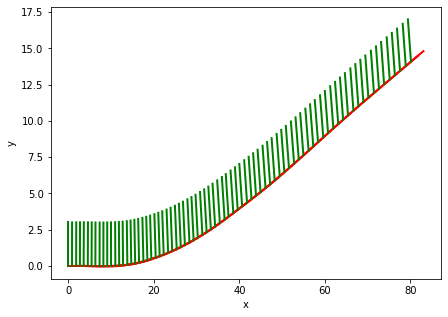

In [7]:
fig,ax = plt.subplots(1, figsize=(7,5))
# ax = plt.axes(projection='3d')

oxts = []
for pos in dataset.oxts:
    oxt = [i for i in pos[0]]
    oxts.append(oxt)

camera_displacement = []
pose = convertOxtsToPose(oxts)
l = 3 # coordinate axis length
A = np.array([[0, 0, 0, 1], [l, 0, 0, 1], [0, 0, 0, 1], [0, l, 0, 1], [0, 0, 0, 1], [0, 0, l, 1]]).transpose()
everyFrame = 1 # plot the vehicle displacement after this many frames
for i in range(0, len(pose), everyFrame):
    B = pose[i].dot(A)
    ax.plot(B[0,0:2],B[1,0:2],color='red',linewidth=2) # x: red
    ax.plot(B[0,2:4],B[1,2:4],color='green',linewidth=2) # y: green
    # ax.plot(B[0,4:6],B[1,4:6],B[2,4:6],color='blue',linewidth=2) # z: blue
    if i > 0:
        coord= []
        coord.append(B[0,0:2][0] - pose[i-everyFrame].dot(A)[0,0:2][0]) # x displacement where positive is forwards
        coord.append(B[1,2:4][0] - pose[i-everyFrame].dot(A)[1,2:4][0]) # x displacement where positive is left turn
        camera_displacement.append(coord)
ax.set_xlabel('x')
ax.set_ylabel('y')
# ax.set_zlabel('z')
plt.show()

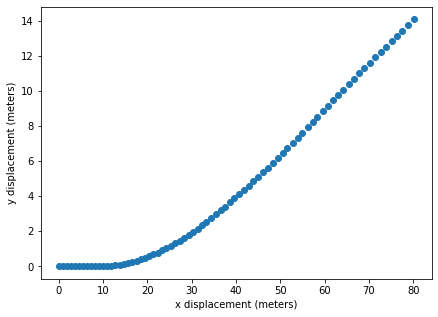

In [8]:
fig,ax = plt.subplots(1, figsize=(7,5))
# x_coordi = [i[0] for i in camera_displacement]
x_coordi, y_coordi = [0], [0]
for i, el in enumerate(camera_displacement):
    x_coordi.append(el[0] + x_coordi[i])
    y_coordi.append(el[1] + y_coordi[i])

ax.scatter(x_coordi, y_coordi)
ax.set_xlabel('x displacement (meters)')
ax.set_ylabel('y displacement (meters)')
plt.show()

## Display Velodyne depth points in the image

In [6]:
# https://stackoverflow.com/questions/45333780/kitti-velodyne-point-to-pixel-coordinate
def prepare_velo_points(pts3d_raw):
    '''Replaces the reflectance value by 1, and tranposes the array, so
       points can be directly multiplied by the camera projection matrix'''

    pts3d = pts3d_raw
    # Reflectance > 0
    pts3d = pts3d[pts3d[:, 3] > 0 ,:]
    pts3d[:,3] = 1
    return pts3d.transpose()

def project_velo_points_in_img(pts3d, T_cam_velo, Rrect, Prect):
    '''Project 3D points into 2D image. Expects pts3d as a 4xN
       numpy array. Returns the 2D projection of the points that
       are in front of the camera only and the corresponding 3D points.'''

    # 3D points in camera reference frame.
    pts3d_cam = Rrect.dot(T_cam_velo.dot(pts3d))

    # Before projecting, keep only points with z>0 
    # (points that are in fronto of the camera).
    idx = (pts3d_cam[2,:]>=0)
    pts2d_cam = Prect.dot(pts3d_cam[:,idx])
    return pts3d[:, idx], pts2d_cam/pts2d_cam[2,:]

In [7]:
pts3d = prepare_velo_points(dataset.get_velo(0))
projectionX = project_velo_points_in_img(pts3d, dataset.calib.T_cam3_velo, dataset.calib.R_rect_30
,dataset.calib.P_rect_30)

pts3d = prepare_velo_points(dataset.get_velo(5))
projectionY = project_velo_points_in_img(pts3d, dataset.calib.T_cam3_velo, dataset.calib.R_rect_30
,dataset.calib.P_rect_30)

<function matplotlib.pyplot.show(*args, **kw)>

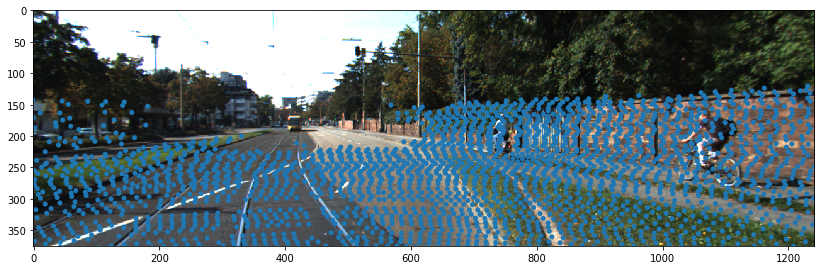

In [8]:
first_cam3 = dataset.get_cam3(0)
fig,ax = plt.subplots(1, figsize=(14,14))
ax.set_aspect('equal')
ax.imshow(first_cam3)
ctr = 0
for src_x, src_y in zip(projectionX[1][0], projectionX[1][1]):
    ctr +=1
    if ctr == 7:
        circ_src = Circle((src_x,src_y), 4)
        ax.add_patch(circ_src)
        ctr = 0
plt.show

# SIFT features

In [9]:
IX_path = '../../openCV_test/images/0000000000.jpg'
IY_path = '../../openCV_test/images/0000000001.jpg'

IX = plt.imread(IX_path)
IY = plt.imread(IY_path)

In [10]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(IX, None)
kp2, des2 = sift.detectAndCompute(IY, None)
bf = cv2.BFMatcher()
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
num_matches = len(matches)
matches = matches[:50]
Xscaled = []
Yscaled = []
for m in matches:
    Xscaled.append(kp1[m.queryIdx].pt)
    Yscaled.append(kp2[m.trainIdx].pt)
Xscaled = np.array(Xscaled)
Yscaled = np.array(Yscaled)

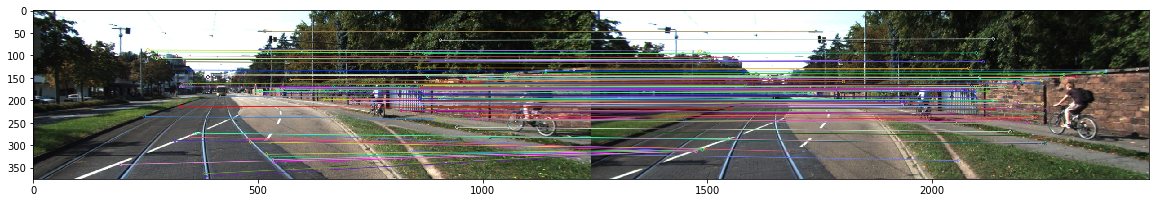

(<matplotlib.image.AxesImage at 0x7f485d57eba8>, None)

In [11]:
img3 = cv2.drawMatches(IX,
                      kp1,
                      IY,
                      kp2,
                      matches[:50],
                      None,
                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20,20))
plt.imshow(img3), plt.show()

## Select features with depth information

In [12]:
featureWithDepthX = np.zeros(shape=(Xscaled.shape[0], Xscaled.shape[1] +2), dtype=np.float64)
featureWithDepthY = np.zeros(shape=(Yscaled.shape[0], Yscaled.shape[1] +2), dtype=np.float64)

projectionX_roundedX = [round(i, 1) for i in projectionX[1][0]]
projectionX_roundedY = [round(i, 1) for i in projectionX[1][1]]
projectionY_roundedX = [round(i, 1) for i in projectionY[1][0]]
projectionY_roundedY = [round(i, 1) for i in projectionY[1][1]]

In [13]:
# its actually 2%
def find5perCent(num, listPro):
    listfeatures = []
    Menys = 0.98 * num
    Mes = 1.02 * num 
    for i, el in enumerate(listPro):
        if el < Mes and el > Menys:
            listfeatures.append(i)
    return listfeatures

In [15]:
for i, feature in enumerate(Xscaled):
    listindX =find5perCent(round(feature[0], 1), projectionX_roundedX)
    listindY =find5perCent(round(feature[1], 1), projectionX_roundedY)
    if len(listindY) > 0 and len(listindX) > 0:
        cand = set(listindX).intersection(listindY) # detect coordindates 
        if len(cand)>0:
            featureWithDepthX[i] = np.append(feature, [True, projectionX[0][0][cand.pop()]])

for i, feature in enumerate(Yscaled):
    listindX =find5perCent(round(feature[0], 1), projectionY_roundedX)
    listindY =find5perCent(round(feature[1], 1), projectionY_roundedY)
    if len(listindY) > 0 and len(listindX) > 0:
        cand = set(listindX).intersection(listindY) # detect coordindates 
        if len(cand)>0:
            featureWithDepthY[i] = np.append(feature, [True, projectionY[0][0][cand.pop()]])

# Display matches with depth information

Number of features: 133
Number of drawn features: 133


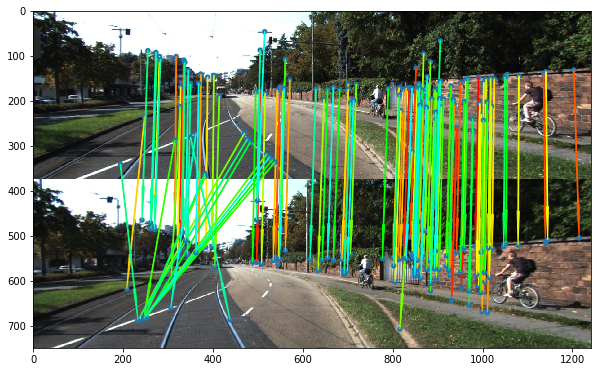

In [20]:
res = np.zeros(shape=(IX.shape[0]+ IY.shape[0], IX.shape[1], 3), dtype=np.uint8)
res[:IX.shape[0], :, :] = IX
res[IX.shape[0]:, :, :] = IY

fig,ax = plt.subplots(1, figsize=(10,10))
ax.set_aspect('equal')
ax.imshow(res)
print(f"Number of features: {Xscaled.shape[0]}")
cmap = get_cmap("hsv")
featuresDepthMatch_ctr = 0
for i, pnt in enumerate(featureWithDepthX):
    if pnt[2] == True and featureWithDepthY[i][2] == True:
        featuresDepthMatch_ctr +=1
        src_x = int(pnt[0])
        src_y = int(pnt[1])
        dst_x = int(featureWithDepthY[i][0])
        dst_y = int(featureWithDepthY[i][1] + IX.shape[0])
        circ_src = Circle((src_x,src_y), 6)
        ax.add_patch(circ_src)
        ax.annotate(featuresDepthMatch_ctr, (src_x, src_y))
        circ_dst = Circle((dst_x,dst_y), 6)
        ax.add_patch(circ_dst)
        ax.annotate(featuresDepthMatch_ctr, (dst_x, dst_y))
        line = Arrow(src_x, src_y, dst_x-src_x, dst_y-src_y, 8, color= cmap(i))
        ax.add_patch(line)
print(f"Number of drawn features: {featuresDepthMatch_ctr}")
plt.show()

In [18]:
difference_listX = []
difference_listY = []
difference_listZ = []
euclideanDistance_list = []

coordinatesSRC = []
coordinatesDST = []
depthListSRC = []
depthListDST = []

for i, pnt in enumerate(featureWithDepthX):
    if pnt[2] == True and featureWithDepthY[i][2] == True:
        src_x = (pnt[1])
        src_y = (pnt[0])
        dst_x = (featureWithDepthY[i][1])
        dst_y = (featureWithDepthY[i][0])

        difference_listX.append(src_x - dst_x)
        difference_listY.append(src_y - dst_y)
        difference_listZ.append(featureWithDepthX[i][3] - featureWithDepthY[i][3])
        euclideanDistance_list.append(dist.euclidean((src_x, src_y), (dst_x, dst_y)))
        
        coordinatesSRC.append(src_x/IY.shape[1])
        coordinatesSRC.append(src_y/IY.shape[0])
        depthListSRC.append(featureWithDepthX[i][3])

        coordinatesDST.append(dst_x/IY.shape[1])
        coordinatesDST.append(dst_y/IY.shape[0])
        depthListDST.append(featureWithDepthY[i][3])

src: 13.444999694824219
dst: 11.885000228881836
src: 12.887999534606934
dst: 11.42300033569336
src: 14.96500015258789
dst: 12.545999526977539
src: 18.399999618530273
dst: 16.929000854492188
src: 13.741000175476074
dst: 11.50100040435791
src: 12.887999534606934
dst: 11.42300033569336
src: 29.073999404907227
dst: 24.56399917602539
src: 16.427000045776367
dst: 15.197999954223633
src: 45.737998962402344
dst: 42.69300079345703
src: 14.753999710083008
dst: 12.880000114440918
src: 10.168000221252441
dst: 8.916999816894531
src: 17.143999099731445
dst: 15.076000213623047
src: 27.302000045776367
dst: 24.211000442504883
src: 17.466999053955078
dst: 15.052000045776367
src: 14.932999610900879
dst: 13.673999786376953
src: 17.988000869750977
dst: 15.593999862670898
src: 19.72800064086914
dst: 16.48200035095215
src: 10.616000175476074
dst: 9.255999565124512
src: 51.60599899291992
dst: 52.178001403808594
src: 10.246999740600586
dst: 9.345000267028809
src: 13.064000129699707
dst: 11.288999557495117
src: